In [13]:
import torch
import numpy as np
from torch import nn
from torch.nn import Parameter
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os.path as osp
import models
import time

from retina_face import config
from deploy import init_model
from models.efficientNet import MyEfficientNet
from openvino.inference_engine import IENetwork, IECore
from torchvision import transforms, utils
from PIL import Image
import cv2
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [10]:
def inferenceByIR(rgbImg):
    model_xml = "model/AFFECTNET_imbalance_10000/FP16/net_011.xml" #指定IR模型檔(*.xml)
    model_bin = "model/AFFECTNET_imbalance_10000/FP16/net_011.bin" #指定IR權重檔(*.bin)
    ie = IECore() #建立推論引擎
    # net = cv.dnn.readNetFromModelOptimizer(model_xml, model_bin) # 讀取IR檔

    # read model
    net = IENetwork(model=model_xml, weights=model_bin) #載入模型及權重
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    exec_net = ie.load_network(network = net, device_name = "CPU")
    n, c, h, w = net.inputs[input_blob].shape #1, 3, 224, 224
    net.batch_size =1

    # predict
    time_0 = time.clock()
    output = exec_net.infer(inputs={input_blob: rgbImg})[out_blob]
    time_1 = time.clock()
    output = torch.Tensor(output)
    probablity = torch.nn.functional.softmax(output, dim=-1).cpu().detach().numpy().copy()
    score = probablity#np.squeeze(score, 1)
    print(score)
    print("Inference time = {:.4f} sec.".format(time_1 - time_0))
    return score

def inferenceByNormal(rgbImg):        
    model = MyEfficientNet()
    model.eval()

    # predict
    rgbImg = rgbImg.unsqueeze(0)
    rgbImg = rgbImg.to(memory_format=torch.channels_last)
    time_0 = time.clock()
    with torch.no_grad():
        output = model(rgbImg)
    time_1 = time.clock()
    probablity = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy().copy()
    score = probablity[:]#np.squeeze(score, 1)
    print(score)
    print("Inference time = {:.4f} sec.".format(time_1 - time_0))
    return score

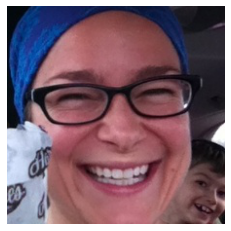

In [8]:
# read data
RGBimg = Image.open("data/test_img_rgb/test.jpg").convert('RGB').resize((224,224))
transf = transforms.Compose([transforms.ToTensor()])
rgbImg = transf(RGBimg)
unloader = transforms.ToPILImage()
image = unloader(rgbImg)

plt.figure()
plt.axis("off")
plt.imshow(image)

In [11]:
CUDA_VISIBLE_DEVICES=None
probs = inferenceByIR(rgbImg)

C:\Users\jiunda\.conda\envs\tf_1_14\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  
C:\Users\jiunda\.conda\envs\tf_1_14\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if __name__ == '__main__':
C:\Users\jiunda\.conda\envs\tf_1_14\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()
[[0.00261795 0.9371848  0.00452014 0.01329916 0.01058912 0.01111775
  0.01013634 0.01053474]]
Inference time = 0.0129 sec.


In [31]:
# 對應標籤
AffectName = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry', 'Contempt']
emo_idx = np.argmax(probs[0],axis=0)
emo_name = AffectName[emo_idx]

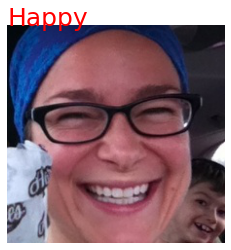

In [30]:
plt.text(0, 0, emo_name, fontsize=25, color="red")
plt.axis("off")
plt.imshow(image)